In [ ]:
from langchain_core.runnables import RunnableLambda
from typing_extensions import Annotated
from typing_extensions import TypedDict
from langchain_community.utilities import OpenWeatherMapAPIWrapper
from typing_extensions import Annotated
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

from langchain_community.tools import QuerySQLDatabaseTool
  

from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from typing_extensions import Annotated
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
import urllib.parse
# from langchain_community.utilities import SQLDatabase
from langchain_community.utilities.sql_database import SQLDatabase
from pydantic import BaseModel

from sqlalchemy import create_engine
import urllib
from PIL import Image
import io
import sys
import os
import re
import pandas as pd


from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
config_memory = {"configurable": {"thread_id": "1"}}
# ----------------------------
# 1. Define Tools
# ----------------------------


database = "demo"
# database="AdventureWorks"
table = "dbo.orders"
# table = "SalesLT.Product"
username = "demo_user"
password = "demo123"
server = r"LAPTOP-QSH9GD6T\SQLEXPRESS"

conn_str = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+11+for+SQL+Server"

db = SQLDatabase.from_uri(conn_str)

# Tool to query SQL Server
query_sql_tool = QuerySQLDataBaseTool(db=db)
                 
# --------------- 🌦️ Weather Tool ---------------

weather = OpenWeatherMapAPIWrapper(openweathermap_api_key ="f422746dad79b71d0156b746d847888b")

# --------------- 🧠 LLM ----------------
sys.path.append(os.path.abspath('C:\genai\Code\stremlit')) 
import main_class
model = main_class.model()
llm = model

# weather = OpenWeatherMapAPIWrapper(openweathermap_api_key=OPENWEATHER_API_KEY)
# class State(BaseModel ):  # <--- add total=False This tells Python and Pydantic that not all fields are required, so you can pass partial state dictionaries without validation errors.
#     messages: Annotated[list, add_messages]
#     question: str
#     query: str
#     result: str
#     answer: str  
#     intent : str 
#     input_value : str


class State(TypedDict , total=False ):  # <--- add total=False This tells Python and Pydantic that not all fields are required, so you can pass partial state dictionaries without validation errors.
    def __init__(self):
        self.messages = []
    messages: Annotated[list, add_messages]
    question: str
    query: str
    result: str
    answer: str  
    output : str
    chart_type : str
    from_query : bool

def ensure_ai_message(state):
    messages = state.get("messages", [])
    if not any(isinstance(m, AIMessage) for m in messages):
        messages = [AIMessage(content="")] + messages
    state["messages"] = messages
    return state



def get_weather(state: State):
    """ get the city name from prompt or message """
    print(" debug :  get the city name from prompt or message ")
    
    user_input = state["messages"][-1].content
    print(f"***get_weather   user input **{user_input}* ")
    
    res = llm.invoke([
        HumanMessage(content=f"""
        You are given a question and must extract the city name from it.
        Respond ONLY with the city name. If no city is found, respond with an empty string.
        Question: {user_input}
        """)
        ])
    city_name = res.content.strip()
    # if not city_name:
        # return {"messages": [AIMessage(content="I couldn't find a city name in your question.")]}
    # return {"messages": [AIMessage(content=f"Extracted city: {city_name}")], "city": city_name}
    """Get current weather for a given city."""
    print(f"🚨 get_weather DEBUG: state = {city_name}")
    return weather.run(city_name)



# @tool
# def fetch_table_data(table: str) -> str:
#     """Fetch table data from the database."""
#     db = SQLDatabase.from_uri(DB_URI)
#     query = f"SELECT * FROM {table} LIMIT 100"
#     result = db.run(query)
#     return result


def get_db_connection(server, database, username, password):
    """
    Connect to the SQL Server database using the provided credentials.
    """
    conn_str = f"mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+11+for+SQL+Server"

    # Create a SQLAlchemy engine
    db2_conn = SQLDatabase.from_uri(conn_str)
    return db2_conn

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer.selected database is microsoft sql server. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"


query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]

# classification_prompt = ChatPromptTemplate.from_messages([
#     ("system", "Classify the user intent into one of: ['weather', 'database', 'other']."),
#     ("human", "User message: {input}")
# ])

classification_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that classifies user input into one of these categories: 'weather', 'database', 'chart' or 'other'. Respond ONLY with one of these words. Do not explain."),
    ("human", "User: What's the weather in Delhi?"),
    ("ai", "weather"),
    ("human", "User: Count the number of customers from table Customer"),
    ("ai", "database"),
    ("human", "User: create a chart or grapgh"),
    ("ai", "chart"),        
    ("human", "User: Tell me a joke"),
    ("ai", "other"),
    ("human", "User: {input}")
])


def detect_intent(user_input: str) -> str:
    try:
        prompt = classification_prompt.invoke({"input": user_input},config=config_memory)
        result = llm.invoke(prompt ,config=config_memory)
        print(f"result ** {result}")
        # return result.content.strip().lower()
        intent = result.content.strip().lower()
        print(f" ********* detect_intent  intent value is **{intent}**   ")
        if intent not in ["weather", "database", "chart"]:
            return "other"
        return intent
    except Exception as e:
        print("❌ Intent detection failed:", e)
        return "other"

def write_query(state: State) -> dict:
    """Generate SQL query to fetch information."""
    print(f" 🚨 DEBUG write_query {state.get('question')}" )
    try:
        db = get_db_connection(server, database, username, password)
        question = state.get("question")
        if not question:
            messages = state.get("messages", [])
            if messages and isinstance(messages[-1], HumanMessage):
                question = messages[-1].content
            # else:
            #     question = ""
                    
        prompt = query_prompt_template.invoke(
            {
                "dialect": db.dialect,
                "top_k": 10,
                "table_info": db.get_table_info(),
                "input": question,   ##state["question"]
            },config=config_memory
        )
        structured_llm = llm.with_structured_output(QueryOutput)
        result = structured_llm.invoke(prompt,config=config_memory)
        print("Generated Query:", result["query"])
        return {"query": result["query"]}
    except Exception as e:
        print("write_query failed:", e)
        return {"query": ""}



def execute_query(state: State):
    """Execute SQL query."""
    print(" 🚨 DEBUG execute_query ")
    db = get_db_connection(server, database, username, password)
    execute_query_tool = QuerySQLDatabaseTool(db=db ,description = '\n    Execute a SQL query against the database and get back the result..\n    If the query is not correct, an error message will be returned.\n    If an error is returned, rewrite the query, check the query, and try again.\n    ')
    return {"result": execute_query_tool.invoke(state["query"],config=config_memory)}




def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    try:
        print("🚨 DEBUG: generate_answer called")
        question = state.get("question", "")
        query = state.get("query", "")
        result = state.get("result", "")
        

        if not (question and query and result):
            raise ValueError("Missing input for generate_answer")

        prompt = (
            "Given the following user question, corresponding SQL query, "
            "and SQL result, answer the user question.\n\n"
            f'Question: {question}\n'
            f'SQL Query: {query}\n'
            f'SQL Result: {result}'
        )

        response = llm.invoke(prompt,config=config_memory)
        print("✅ Answer Generated:", response.content)
        return {"output": response.content}
    except Exception as e:
        print("❌ ERROR in generate_answer:", e)
        return {"answer": "An error occurred while generating the answer."}




# ----------------------------
# 2. State Setup
# ----------------------------

# class State(dict):
#     pass


def route(state: State) -> dict:
    
    print("** DEBUG  route(state: State) : ** ", state)


    messages = state.get("messages", [])

    if not any(isinstance(m, AIMessage) for m in messages):
        messages = [AIMessage(content="")] + messages
        
    if messages and isinstance(messages[-1], HumanMessage):
        user_input = messages[-1].content.strip().lower()
    else:
        user_input = "default"

    intent = detect_intent(user_input).strip().lower()        
    print(f"[Router] input = {user_input}")

    print(f"  ***   outside the if condition func route   intent value is   *{intent}*")
    
    if  "weather" in intent:
        print(f"🌦️ Route: weather_node  message **{messages} **")
        return {"next": "weather_node", "messages": user_input}
    elif any(k in user_input for k in ["table", "database", "query", "sql", "data", "record", "column"]):     ###intent == "database":
        print("📊 Route: table_node")
        return {"next": "table_node", "messages": messages, "question": user_input}
    elif "chart" in intent:
        print("📊 Route: chart_node")
        return {"next": "chart_node", "messages": user_input}
    else:
        print("❓ Route: default")
        return {"next": "default", "messages": messages}    
    


def table_tool_node(state: State) -> State:
    print("🚨 Entered table_tool_node")

    # Step 1: Write SQL query
    result1 = write_query(state)
    state.update(result1)
    print("✅ write_query output:", result1)

    # Step 2: Execute SQL query
    result2 = execute_query(state)
    state.update(result2)
    print("✅ execute_query output:", result2)

    # Add to messages for UI
    
    # chart_type = get_chart_type(state.get('question'))
    # if chart_type:  
    #     # state["messages"].append(AIMessage(content=f"Chart type detected: {chart_type}"))
    #     state["chart_type"] = chart_type
    #     print(f"🚨 chart_type detected: {chart_type}")  
    state["from_query"] = True
    #     create_chart(state) 
    # else:
    # Step 3: Generate final answer
    result3 = generate_answer(state)
    state.update(result3)
    print("✅ generate_answer output:", result3)        
    
    state["messages"] = state.get("messages", []) + [AIMessage(content=state.get("answer", "No answer"))]
    return state




def get_chart_type(state: State):
    """ get the chart type from prompt or message """
    print(" debug :  get the chart type from prompt or message  ")
    question = state.get("question", "")
    query = state.get("query", "")
    result = state.get("result", "")
    print(f"***get_chart_type   question **{question}* ")
    print(f"***get_chart_type   query **{query}* ")     
    print(f"***get_chart_type   result **{result}* ")

    

    user_input = state["messages"][-1].content
    print(f"***get_chart_type   user input **{user_input}* ")



    res = llm.invoke([
        HumanMessage(content=f"""
        1. You are a helpful assistant that extracts the chart type from user input.
        2. You will be given a question and must extract the visualization type from it.                         
        3. Respond ONLY with the visualization type. If no visualization is found, respond with an empty string.
        4. The visualization types can be: 'bar', 'line', 'scatter', 'pie', 'histogram', 'boxplot', 'heatmap', 'area', 'donut', 'radar', 'funnel', 'treemap', or 'wordcloud'.
        5. If the question does not specify a visualization type, respond with an empty string  
        Question: {question}
        """)
        ])
    chart_name = res.content.strip()
    state["chart_type"] = chart_name
    print(f"🚨 get_chart_type DEBUG: state = {chart_name}")
   
    return {"chart_type" :chart_name }

def create_chart(state :State) :
    """Create a chart or graph using the dataframe result set"""
    # user_input = state["messages"][-1].content
    # chart_type = get_chart_type(state.get('question'))

    chart_type = get_chart_type(state)
    print(f'Create a chart or graph using the dataframe result set **{state["from_query"] }**')

    print("************************************************")
    question = state.get("question", "")
    query = state.get("query", "")
    result = state.get("result", "")
    print(f"***get_chart_type   question **{question}* ")
    print(f"***get_chart_type   query **{query}* ")     
    print(f"***get_chart_type   result **{result}* ")
    print("************************************************")    
    if state["from_query"] :
        print("🚨 create_chart called with from_query set to True. Proceeding with chart creation.")
        df = pd.read_sql(state.get("query", ""),  db._engine.connect()  )
        df_columns =df.columns
        
        
        df.plot(kind=state["chart_type"], x=df_columns[0], y=df_columns[1])   
    else:
        print("🚨 create_chart called without from_query set to True. Skipping chart creation.")
        # chart_type = get_chart_type(state)
    if not chart_type:  
        print("❌ No chart type found in state.")
        return {"output": "No chart type specified."}
    print(f"🚨 Entered create_chart {chart_type}")
    return 

def is_chart_request(user_input: str) -> bool:
    return bool(re.search(r"\b(chart|graph|plot|visualize)\b", user_input.lower()))


weather_tool = RunnableLambda(lambda state: {"output": get_weather(state)})
chart_tool = RunnableLambda(lambda state: {"output": create_chart(state)})


C:\Users\ajsin\AppData\Local\Temp\ipykernel_8760\311041732.py:58: LangChainDeprecationWarning: The class `QuerySQLDataBaseTool` was deprecated in LangChain 0.3.12 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-community package and should be used instead. To use it run `pip install -U :class:`~langchain-community` and import as `from :class:`~langchain_community.tools import QuerySQLDatabaseTool``.
  query_sql_tool = QuerySQLDataBaseTool(db=db)
C:\Users\ajsin\AppData\Local\Temp\ipykernel_8760\311041732.py:66: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are worki

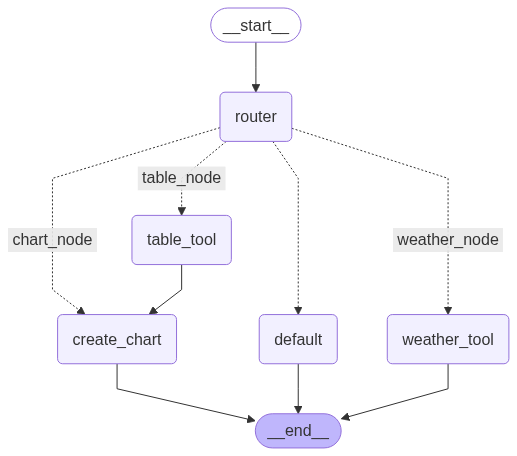

In [3]:
# def default_response(state: State) -> dict:
#     return {"output": "Please ask about a table or a city for weather."}

def default_response(state: State) -> State:
    # return {"messages": [model.invoke(state["messages"])]}
    return {"messages": [llm.invoke(state["messages"],config=config_memory)] }
# ----------------------------
# 4. LangGraph Creation
# ----------------------------

graph = StateGraph(State)
graph.add_node("router", route)
graph.add_node("weather_tool", weather_tool)
graph.add_node("create_chart", chart_tool)

graph.add_node("table_tool", table_tool_node)

graph.add_node("default", default_response)

graph.set_entry_point("router")
# graph.add_conditional_edges(
#     "router", lambda state: route(state),
#     {
#         "weather_tool": "weather_tool",
#         "table_tool": "table_tool",
#         "default": "default"
#     }
# )
graph.add_conditional_edges(
    "router",
    # 👇 key to look inside router's return value
    lambda state: state["next"],
    path_map={
        "weather_node": "weather_tool",
        "table_node": "table_tool",
        "chart_node" : "create_chart" ,
        "default": "default"
    }
)
graph.add_edge("weather_tool", END)
# graph.add_edge("table_tool", "create_chart")
graph.add_edge("table_tool", "create_chart")
graph.add_edge("default", END)

app = graph.compile()

from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
# print(detect_intent("weather of Noida"))         # 👉 Should return "weather"
# print(detect_intent("show product data"))        # 👉 Should return "database"
# print(detect_intent("who is elon musk"))         # 👉 Should return "other"
print(detect_intent("using customer tables create line chart"))         # 👉 Should return "other"


result ** content='chart' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 128, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_e6529acef4', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'protected_material_code': {'filtered': False, 'detected': False}, 'protected_material_text': {'filte

** DEBUG  route(state: State) : **  {'messages': [HumanMessage(content='using customer tables create line chart', additional_kwargs={}, response_metadata={}, id='5ea197f0-6630-43ff-9639-c50011bee70f')]}
result ** content='chart' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 128, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'detected': False, 'filtered': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 

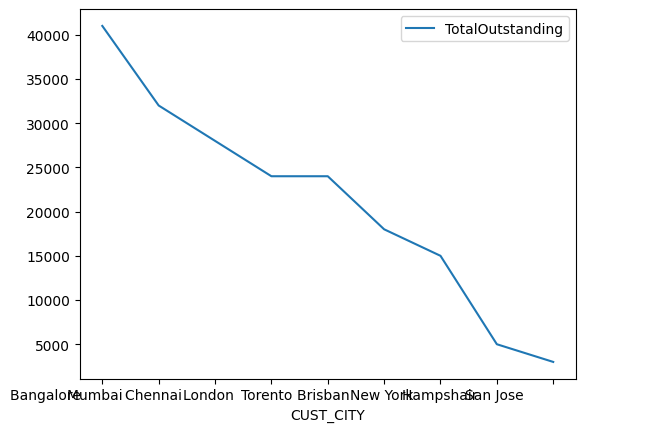

In [5]:
result = app.invoke({
    "messages": [HumanMessage(content="using customer tables create line chart")]
})
print(result)
# print(result.get("output", result))

In [16]:
result = app.invoke({"messages": "weather Noida"})
output = result.get("output")


result = app.invoke({"messages": [HumanMessage(content="weather of Noida")]  })
print(result["output"])



** DEBUG  route(state: State) : **  {'messages': [HumanMessage(content='weather Noida', additional_kwargs={}, response_metadata={}, id='c7d731eb-3c3b-4db3-b4ef-cea14869c448')]}
result ** content='weather' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 2, 'prompt_tokens': 125, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-11-20', 'system_fingerprint': 'fp_ee1d74bde0', 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'severity': 'safe'}}}], 'finish_reason': 'stop', 'logprobs': None

In [9]:
# result = app.invoke({
#     "messages": [HumanMessage(content="count the number of customers from table customers")]
# })

# print("📦 FINAL RESULT:", result)
# print("📢 ANSWER:", result.get("answer", "No answer found"))

In [10]:
# result = app.invoke({
#     "messages": [HumanMessage(content="what is oracle")]
# })
# # Get last AIMessage
# ai_messages = [msg for msg in result["messages"] if isinstance(msg, AIMessage)]

# if ai_messages:
#     print("\n📢 Final Response:\n")
#     print(ai_messages[-1].content)
# else:
#     print("❌ No AI response found.")

In [11]:
aa="intent: weather"

if "weather" in aa :
    print(" found weather")
else:
    print("Not found weather")

 found weather


In [12]:
# graph.add_node("table_tool", table_tool_node)
# graph.add_node("table_tool", lambda state: ToolNode(tools)(ensure_ai_message(state)))
# graph.add_node("table_tool", lambda state: llm_with_tools.invoke(state["messages"]))


# res = llm.invoke([
#     HumanMessage(content="""
#     Classify this input as 'weather', 'database', or 'other':
#     "count the number of customers from table customer"
#     """)
# ])
# print(res.content)